<div style="background-color:black;color:white;font-size:25px;font-weight:bold;">
    <p style='line-height:39px;margin:14px;'>1.爬取武汉市卫健委新冠肺炎疫情动态通知公告，取得新增确诊，新增疑似，新增出院，新增死亡，
    各区及全市疫情统计，全市发热门诊接诊数，首诊数，较前日变化，核酸检测人数等数据</p>
    <p style='line-height:39px;margin:14px;'>2.整理数据，得到可分析样本</span><br/>
    <p style='line-height:39px;margin:14px;'>3.计算出发热确诊转化率，核酸确诊转化率，各区增长占比等高阶指标</span><br/>
    <p style='line-height:39px;margin:14px;'>4.分析各指标随时间变化趋势</span>
</div>

In [1]:
import re
import requests
#from urllib import request,parse
from bs4 import BeautifulSoup as bs

from datetime import*
import time     #一定要写在datetime后面

import json
from selenium import webdriver

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
headers_for_articleUrl = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
    'Accept-Encoding': 'gzip, deflate',
    'Accept-Language': 'zh-CN,zh;q=0.8,zh-TW;q=0.7,zh-HK;q=0.5,en-US;q=0.3,en;q=0.2',
    'Connection': 'keep-alive',
    'Content-Length': '76',
    'Content-Type': 'application/x-www-form-urlencoded',
    'Cookie': 'JSESSIONID=A0DF38700D89364D8D9331535E88943C; Hm_lvt_ac084bfb4d82ed021aed64d30fe62ff0=1581705926,1582990037,1582995137,1583467814; Hm_lpvt_ac084bfb4d82ed021aed64d30fe62ff0=1583908249; Hm_lvt_accce6dfdb6e60ff017877cadf0a4ad9=1583463493; Hm_lpvt_accce6dfdb6e60ff017877cadf0a4ad9=1583463829; _va_id=705df202bcd736fb.1583463493.1.1583463835.1583463493.; b9f53a5dc3c146b0884722b3c53fdb0f=WyIyMDQyMzcwMjMwIl0',
    'Host': 'wjw.wuhan.gov.cn',
    'Referer': 'http://wjw.wuhan.gov.cn/front/web/list3rd/yes/803',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:69.0) Gecko/20100101 Firefox/69.0'
}

In [3]:
data_for_articleUrl = {
                        'pageNum':1,
                        'numPerPage':15,
                        'orderField':'publishDate',
                        'orderDirection':'DESC'
                       }

In [4]:
url_main = 'http://wjw.wuhan.gov.cn/front/web/list3rd/yes/803'
article_url_list = []     #存放具体文章的链接
pattern_pick_digital = re.compile("\d+")
cur_page = 0
total_page = 0

while cur_page <= total_page:
    print(f"请求第{data_for_articleUrl['pageNum']}页：")
    response_for_articleList = requests.post(url=url_main,headers=headers_for_articleUrl,data=data_for_articleUrl)
    response_articleList_text = response_for_articleList.text
    articleList_page_model = bs(response_articleList_text,'lxml')
    all_articleList = articleList_page_model.find(class_='xxgksublist').find_all('a')

    #爬取页数控制
    page_info = articleList_page_model.find(class_='control').find('span').text
    total_page = int(pattern_pick_digital.findall(page_info)[1])
    cur_page = int(pattern_pick_digital.findall(page_info)[2])
    print(f"总页数：{total_page}，当前页：{cur_page}；参数当前页：{data_for_articleUrl['pageNum']}")
    if cur_page != int(data_for_articleUrl['pageNum']):
         break

    #获得所有符合条件的文章的链接
    for articleHref in all_articleList:
        if articleHref['title'].find('武汉市新冠肺炎疫情动态') == -1:
            continue
        else:
            article_href = articleHref['href']
            print(article_href)
            article_url_list.append(article_href)
    data_for_articleUrl['pageNum'] = data_for_articleUrl['pageNum'] + 1
print(f'共得到：{len(article_url_list)}篇链接')
data_for_articleUrl['pageNum'] = '1'

请求第1页：
总页数：14，当前页：1；参数当前页：1
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020031110061
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020031010046
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030910033
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030810016
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030710001
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030609985
请求第2页：
总页数：14，当前页：2；参数当前页：2
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030509963
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030409947
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030309923
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030209901
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030109892
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020022909862
请求第3页：
总页数：14，当前页：3；参数当前页：3
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020022809843
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020022709829
http://wjw.wuhan.gov.cn:80/front/web/showDetail/

In [5]:
def put_item_into_special_list(record_date,mother_list,item_list,pattern_str):
    temp_list = [None]*(len(mother_list[0]))
    other_list = [None]*(len(mother_list[0]))
    temp_list[0] = record_date
    
    for item in item_list:
        if pattern_str.findall(item) != []:     #有可能出现每篇文章关键词出现顺序不同或缺少关键词的情况,这里根据关键词出现的位置灵活调整
            field = pattern_str.search(item).group(0)
            value = pattern_pick_digital.search(item).group(0)
            temp_index = mother_list[0].index(field)
            temp_list[temp_index] = value
        else:
            continue
    mother_list.append(temp_list)

def put_item_into_common_list(record_date,mother_list,item_list):
    print(f'待处理通用数据列：{item_list}')
    temp_data_list = []
    temp_data_list.append(record_date)
    pattern_filter = re.compile('\d+月\d+日')
    for item in item_list:
        if pattern_filter.findall(item) != [] or item == None:
            continue
        else:
            di_list = pattern_pick_digital.findall(item)
            for di in di_list:
                temp_data_list.append(di)
    mother_list.append(temp_data_list)

In [6]:
header_for_detail = {
                        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                        'Accept-Encoding': 'gzip, deflate',
                        'Accept-Language': 'zh-CN,zh;q=0.8,zh-TW;q=0.7,zh-HK;q=0.5,en-US;q=0.3,en;q=0.2',
                        'Connection': 'keep-alive',
                        'Cookie': 'JSESSIONID=2E16D6B111244AAE6D80FC840C499145; Hm_lvt_ac084bfb4d82ed021aed64d30fe62ff0=1581705926,1582990037,1582995137,1583467814; Hm_lpvt_ac084bfb4d82ed021aed64d30fe62ff0=1583572815; Hm_lvt_accce6dfdb6e60ff017877cadf0a4ad9=1583463493; Hm_lpvt_accce6dfdb6e60ff017877cadf0a4ad9=1583463829; _va_id=705df202bcd736fb.1583463493.1.1583463835.1583463493.; b9f53a5dc3c146b0884722b3c53fdb0f=WyIzNDQ4NTk0NDU1Il0',
                        'Host': 'wjw.wuhan.gov.cn',
                        'Referer': 'http://wjw.wuhan.gov.cn/front/web/list3rd/yes/803',
                        'Upgrade-Insecure-Requests': '1',
                        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:69.0) Gecko/20100101 Firefox/69.0'
                    }

In [7]:
new_list = [['date','新增确诊病例','新增出院病例','新增死亡病例','新增疑似病例']]     #需要匹配文章的词组,故暂时使用中文,在dataFrame中改回,下同
total_stat_list = [['date','total_confirm','total_cure','total_dead','total_rest','rest_dangerous','rest_heavy','total_seemingly']]
loc_stat_list = [['date','江岸区','江汉区','硚口区','汉阳区','武昌区','青山区','洪山区','东西湖区','蔡甸区','江夏区','黄陂区',\
                   '新洲区','武汉开发区','东湖开发区','东湖风景区','外地区']]
# daily_info_list = ['date','fever_clinics','compare_last','first_visit','nucleic_acid_testing']
daily_info_list = [['date','fever_clinics','compare_last','first_visit','nucleic_acid_testing']]     #注意：初始化的时候是双层list

pattern_date = re.compile('\d+年\d+月\d+日')
pattern_new = re.compile('新增\w+病例')
pattern_loc = re.compile('\w+区')

for article_url in article_url_list:
    print(article_url)
    rest_text_list = []     #存放散装数据
    article_response_text = requests.get(article_url,headers=header_for_detail).text
    article_page_model = bs(article_response_text,'lxml')
    
    title_text = article_page_model.find(id='detailTitle').text
    record_date_str = pattern_date.findall(title_text)[0]
    record_date_arr = time.strptime(record_date_str,u'%Y年%M月%d日')
    record_date = time.strftime(u'%Y-%M-%d',record_date_arr)
    
    content_list = article_page_model.find(id='detailContent').find_all('p')
    if pattern_loc.search(content_list[1].text) == None:     #最开始一天数据与其它不同，直接丢弃
        break
    
    new_data = content_list[0].text.replace(',','，',-1)     #应对中英文逗号混用
    put_item_into_special_list(record_date,new_list,new_data.split("，"),pattern_new)     #新增部分专项处理
    
    total_stat_data = content_list[1].text.replace('按行政区','按现住址',-1).replace('经开汉南区','武汉开发区',-1).replace('外地','外地区',-1).replace('。','，',-1)
    text_piece = total_stat_data.split('，')
    put_item_into_special_list(record_date,loc_stat_list,text_piece[2].split("、"),pattern_loc)     #分区部分专项处理
    for i,piece in enumerate(text_piece):
        if i == 2:
            continue
        else:
            rest_text_list.append(piece)
    put_item_into_common_list(record_date,total_stat_list,rest_text_list)     #其余部分放进通用处理
    
    daily_data = content_list[2].text.replace('。','，',-1).replace(',','，',-1)
    daily_piece = daily_data.split('，')
    #daily_text = daily_piece[0].split('，') + daily_piece[1].split('，')
    put_item_into_common_list(record_date,daily_info_list,daily_piece)     #日报信息部分放进通用处理

http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020031110061
待处理通用数据列：['截至2020年3月10日24时', '全市累计报告确诊病例49978例', '累计治愈出院33041人', '累计死亡2423人', '全市现有确诊病例14514人（危重715人', '重症3502人）', '现有疑似病例192例', '']
待处理通用数据列：['3月9日18时-3月10日18时', '全市发热门诊接诊682人次', '较前日减少113人次', '其中首诊350人', '3月10日当日', '全市核酸检测19379人', '']
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020031010046
待处理通用数据列：['截至2020年3月9日24时', '全市累计报告确诊病例49965例', '累计治愈出院31829人', '累计死亡2404人', '全市现有确诊病例15732人（危重749人,重症3722人）', '现有疑似病例230例', '']
待处理通用数据列：['3月8日18时至3月9日18时', '全市发热门诊接诊795人次', '较前日减少67人次', '其中首诊395人', '3月9日当日', '全市核酸检测26138人', '']
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030910033
待处理通用数据列：['截至2020年3月8日24时', '全市累计报告确诊病例49948例', '累计治愈出院30933人', '累计死亡2388人', '全市现有确诊病例16627人（危重791人,重症3944人）', '现有疑似病例253例', '']
待处理通用数据列：['3月7日18时至3月8日18时', '全市发热门诊接诊862人次', '较前日减少258人次', '其中首诊502人', '3月8日当日', '全市核酸检测24807人', '']
http://wjw.wuhan.gov.cn:80/front/web/showDetail/2020030810016
待处理通用数据列：['截至2020年3月7日24时', '全市累计报告确诊病例49912例', '累计治愈出

In [8]:
dict_loc = dict(zip(['loc_ja','loc_jh','loc_qk','loc_hy','loc_wc','loc_qs','loc_hs','loc_dxh','loc_cd',\
                    'loc_jx','loc_hp','loc_xz','loc_hn','loc_gg','loc_ddfjq','loc_outer'],\
                ['江岸区','江汉区','硚口区','汉阳区','武昌区','青山区','洪山区','东西湖区','蔡甸区','江夏区','黄陂区',\
                   '新洲区','武汉开发区','东湖开发区','东湖风景区','外地区']))

In [9]:
df_new = pd.DataFrame(new_list[1:],columns=['date','new_confirm','new_cure','new_dead','new_seemingly'])
df_new

,date,new_confirm,new_cure,new_dead,new_seemingly
0,2020-03-10,13,1212,19,6
1,2020-03-09,17,896,16,12
2,2020-03-08,36,1163,18,28
3,2020-03-07,41,1259,21,42
4,2020-03-06,74,1157,21,46
5,2020-03-05,126,1038,23,42
6,2020-03-04,131,1426,23,61
7,2020-03-03,114,1859,31,43
8,2020-03-02,111,1846,24,62
9,2020-03-01,193,1958,32,70


In [10]:
df_loc = pd.DataFrame(loc_stat_list[1:],columns=['date','loc_ja','loc_jh','loc_qk','loc_hy','loc_wc','loc_qs','loc_hs','loc_dxh','loc_cd',\
                                                 'loc_jx','loc_hp','loc_xz','loc_hn','loc_gg','loc_ddfjq','loc_outer'])
df_loc

,date,loc_ja,loc_jh,loc_qk,loc_hy,loc_wc,loc_qs,loc_hs,loc_dxh,loc_cd,loc_jx,loc_hp,loc_xz,loc_hn,loc_gg,loc_ddfjq,loc_outer
0,2020-03-10,6546,5179,6829,4668,7454,2782,4675,2462,1416,848,2114,1072,1084,2145,478,226
1,2020-03-09,6546,5175,6827,4668,7453,2781,4671,2462,1416,848,2114,1071,1084,2144,478,227
2,2020-03-08,6546,5173,6822,4666,7450,2780,4670,2462,1416,848,2114,1071,1083,2144,476,227
3,2020-03-07,6539,5164,6809,4666,7445,2778,4661,2461,1416,848,2114,1071,1083,2143,476,238
4,2020-03-06,6532,5149,6802,4664,7443,2775,4660,2460,1416,848,2113,1070,1084,2140,475,240
5,2020-03-05,6521,5137,6789,4661,7431,2773,4652,2459,1415,998,2113,1070,1083,1979,474,242
6,2020-03-04,4352,7344,7305,3605,8315,2985,5109,2604,1993,1704,1780,1023,1552,None,None,None
7,2020-03-03,4347,7333,7271,3601,8301,2980,5090,2602,1990,1688,1780,1023,1534,None,None,None
8,2020-03-02,4332,7322,7264,3588,8272,2980,5079,2601,1983,1682,1778,1021,1524,None,None,None
9,2020-03-01,4318,7308,7250,3586,8242,2974,5072,2593,1981,1675,1777,1021,1518,None,None,None


In [11]:
df_total = pd.DataFrame(total_stat_list[1:],columns=total_stat_list[0])
df_total

,date,total_confirm,total_cure,total_dead,total_rest,rest_dangerous,rest_heavy,total_seemingly
0,2020-03-10,49978,33041,2423,14514,715,3502,192
1,2020-03-09,49965,31829,2404,15732,749,3722,230
2,2020-03-08,49948,30933,2388,16627,791,3944,253
3,2020-03-07,49912,29770,2370,17772,824,4026,258
4,2020-03-06,49871,28511,2349,19011,843,4185,256
5,2020-03-05,49797,27354,2328,20115,863,4345,232
6,2020-03-04,49671,26316,2305,21050,894,4448,247
7,2020-03-03,49540,24890,2282,22368,972,4751,234
8,2020-03-02,49426,23031,2251,24144,997,5023,316
9,2020-03-01,49315,21185,2227,25903,1021,5204,340


In [12]:
df_daily = pd.DataFrame(daily_info_list[1:],columns=daily_info_list[0])
df_daily

,date,fever_clinics,compare_last,first_visit,nucleic_acid_testing
0,2020-03-10,682,113,350,19379
1,2020-03-09,795,67,395,26138
2,2020-03-08,862,258,502,24807
3,2020-03-07,1120,132,664,20196
4,2020-03-06,1252,148,748,24943
5,2020-03-05,1400,305,784,28922
6,2020-03-04,1705,122,1062,23136
7,2020-03-03,1827,386,1050,28637
8,2020-03-02,2213,492,1258,21202
9,2020-03-01,2705,159,1585,18127


### 合并，清洗数据

In [13]:
df_whole = pd.merge(df_total,df_loc,how='left',on='date').merge(df_new,on='date',how='left').merge(df_daily,on='date',how='left')
df_whole

,date,total_confirm,total_cure,total_dead,total_rest,rest_dangerous,rest_heavy,total_seemingly,loc_ja,loc_jh,...,loc_ddfjq,loc_outer,new_confirm,new_cure,new_dead,new_seemingly,fever_clinics,compare_last,first_visit,nucleic_acid_testing
0,2020-03-10,49978,33041,2423,14514,715,3502,192,6546,5179,...,478,226,13,1212,19,6,682,113,350,19379
1,2020-03-09,49965,31829,2404,15732,749,3722,230,6546,5175,...,478,227,17,896,16,12,795,67,395,26138
2,2020-03-08,49948,30933,2388,16627,791,3944,253,6546,5173,...,476,227,36,1163,18,28,862,258,502,24807
3,2020-03-07,49912,29770,2370,17772,824,4026,258,6539,5164,...,476,238,41,1259,21,42,1120,132,664,20196
4,2020-03-06,49871,28511,2349,19011,843,4185,256,6532,5149,...,475,240,74,1157,21,46,1252,148,748,24943
5,2020-03-05,49797,27354,2328,20115,863,4345,232,6521,5137,...,474,242,126,1038,23,42,1400,305,784,28922
6,2020-03-04,49671,26316,2305,21050,894,4448,247,4352,7344,...,None,None,131,1426,23,61,1705,122,1062,23136
7,2020-03-03,49540,24890,2282,22368,972,4751,234,4347,7333,...,None,None,114,1859,31,43,1827,386,1050,28637
8,2020-03-02,49426,23031,2251,24144,997,5023,316,4332,7322,...,None,None,111,1846,24,62,2213,492,1258,21202
9,2020-03-01,49315,21185,2227,25903,1021,5204,340,4318,7308,...,None,None,193,1958,32,70,2705,159,1585,18127


In [14]:
df_whole.columns

Index(['date', 'total_confirm', 'total_cure', 'total_dead', 'total_rest',
       'rest_dangerous', 'rest_heavy', 'total_seemingly', 'loc_ja', 'loc_jh',
       'loc_qk', 'loc_hy', 'loc_wc', 'loc_qs', 'loc_hs', 'loc_dxh', 'loc_cd',
       'loc_jx', 'loc_hp', 'loc_xz', 'loc_hn', 'loc_gg', 'loc_ddfjq',
       'loc_outer', 'new_confirm', 'new_cure', 'new_dead', 'new_seemingly',
       'fever_clinics', 'compare_last', 'first_visit', 'nucleic_acid_testing'],
      dtype='object')

In [15]:
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 32 columns):
date                    18 non-null object
total_confirm           18 non-null object
total_cure              18 non-null object
total_dead              18 non-null object
total_rest              18 non-null object
rest_dangerous          18 non-null object
rest_heavy              18 non-null object
total_seemingly         18 non-null object
loc_ja                  18 non-null object
loc_jh                  18 non-null object
loc_qk                  18 non-null object
loc_hy                  18 non-null object
loc_wc                  18 non-null object
loc_qs                  18 non-null object
loc_hs                  18 non-null object
loc_dxh                 18 non-null object
loc_cd                  18 non-null object
loc_jx                  18 non-null object
loc_hp                  18 non-null object
loc_xz                  18 non-null object
loc_hn                  18 non-null o

In [16]:
df_wh = df_whole.iloc[:,1:].apply(pd.to_numeric)
df_wh.insert(0,'date',df_whole.date)

In [17]:
df_wh = df_wh.sort_values(by='date',ascending=True)     #先升序，便于画图
df_wh

,date,total_confirm,total_cure,total_dead,total_rest,rest_dangerous,rest_heavy,total_seemingly,loc_ja,loc_jh,...,loc_ddfjq,loc_outer,new_confirm,new_cure,new_dead,new_seemingly,fever_clinics,compare_last,first_visit,nucleic_acid_testing
17,2020-02-22,46201,8171,1856,36174,1454,7774,2382,4117,7099,...,NaN,NaN,NaN,965,82,454,3547,196,2279,17767
16,2020-02-23,46607,8946,1987,35674,1305,7024,1877,4106,7112,...,NaN,NaN,NaN,772,131,318,3394,153,2230,14946
15,2020-02-24,47071,10337,2043,34691,1264,6383,1529,4195,7152,...,NaN,NaN,NaN,1391,56,282,3467,73,2287,18790
14,2020-02-25,47441,11793,2085,33545,1182,6173,1447,4223,7203,...,NaN,NaN,NaN,1456,42,242,3485,18,2380,18547
13,2020-02-26,47824,13328,2104,32392,1103,5946,1459,4239,7227,...,NaN,NaN,NaN,1535,19,341,2911,574,1948,20100
12,2020-02-27,48137,15826,2132,30179,1082,5693,1488,4252,7250,...,NaN,NaN,313.0,2498,28,295,2977,66,1886,23495
11,2020-02-28,48557,17552,2169,28836,1056,5529,788,4275,7276,...,NaN,NaN,420.0,1726,37,114,2626,351,1649,20993
10,2020-02-29,49122,19227,2195,27700,1019,5374,393,4300,7290,...,NaN,NaN,565.0,1675,26,50,2546,80,1591,22277
9,2020-03-01,49315,21185,2227,25903,1021,5204,340,4318,7308,...,NaN,NaN,193.0,1958,32,70,2705,159,1585,18127
8,2020-03-02,49426,23031,2251,24144,997,5023,316,4332,7322,...,NaN,NaN,111.0,1846,24,62,2213,492,1258,21202


In [18]:
df_describe = df_whole.describe().T
df_describe     #经查验，多数count！=unique仅仅为数值相等，其余情况为存在空值

,count,unique,top,freq
date,18,18,2020-03-04,1
total_confirm,18,18,47441,1
total_cure,18,18,27354,1
total_dead,18,18,2305,1
total_rest,18,18,21050,1
rest_dangerous,18,18,1454,1
rest_heavy,18,18,3944,1
total_seemingly,18,18,256,1
loc_ja,18,16,6546,3
loc_jh,18,18,7290,1


In [19]:
df_wh.isnull().sum()

date                     0
total_confirm            0
total_cure               0
total_dead               0
total_rest               0
rest_dangerous           0
rest_heavy               0
total_seemingly          0
loc_ja                   0
loc_jh                   0
loc_qk                   0
loc_hy                   0
loc_wc                   0
loc_qs                   0
loc_hs                   0
loc_dxh                  0
loc_cd                   0
loc_jx                   0
loc_hp                   0
loc_xz                   0
loc_hn                   0
loc_gg                  12
loc_ddfjq               12
loc_outer               12
new_confirm              5
new_cure                 0
new_dead                 0
new_seemingly            0
fever_clinics            0
compare_last             0
first_visit              0
nucleic_acid_testing     0
dtype: int64

In [20]:
df_wh.new_confirm

17      NaN
16      NaN
15      NaN
14      NaN
13      NaN
12    313.0
11    420.0
10    565.0
9     193.0
8     111.0
7     114.0
6     131.0
5     126.0
4      74.0
3      41.0
2      36.0
1      17.0
0      13.0
Name: new_confirm, dtype: float64

In [21]:
df_wh.new_confirm = df_wh.new_confirm.fillna(df_wh.total_confirm-df_wh.shift(periods=1).total_confirm)
df_wh.new_confirm     #最前面的Nan可忽略

17      NaN
16    406.0
15    464.0
14    370.0
13    383.0
12    313.0
11    420.0
10    565.0
9     193.0
8     111.0
7     114.0
6     131.0
5     126.0
4      74.0
3      41.0
2      36.0
1      17.0
0      13.0
Name: new_confirm, dtype: float64

In [22]:
df_wh.compare_last = (df_wh.fever_clinics-df_wh.shift(periods=1).fever_clinics)
df_wh.compare_last

17      NaN
16   -153.0
15     73.0
14     18.0
13   -574.0
12     66.0
11   -351.0
10    -80.0
9     159.0
8    -492.0
7    -386.0
6    -122.0
5    -305.0
4    -148.0
3    -132.0
2    -258.0
1     -67.0
0    -113.0
Name: compare_last, dtype: float64

In [23]:
df_wh

,date,total_confirm,total_cure,total_dead,total_rest,rest_dangerous,rest_heavy,total_seemingly,loc_ja,loc_jh,...,loc_ddfjq,loc_outer,new_confirm,new_cure,new_dead,new_seemingly,fever_clinics,compare_last,first_visit,nucleic_acid_testing
17,2020-02-22,46201,8171,1856,36174,1454,7774,2382,4117,7099,...,NaN,NaN,NaN,965,82,454,3547,NaN,2279,17767
16,2020-02-23,46607,8946,1987,35674,1305,7024,1877,4106,7112,...,NaN,NaN,406.0,772,131,318,3394,-153.0,2230,14946
15,2020-02-24,47071,10337,2043,34691,1264,6383,1529,4195,7152,...,NaN,NaN,464.0,1391,56,282,3467,73.0,2287,18790
14,2020-02-25,47441,11793,2085,33545,1182,6173,1447,4223,7203,...,NaN,NaN,370.0,1456,42,242,3485,18.0,2380,18547
13,2020-02-26,47824,13328,2104,32392,1103,5946,1459,4239,7227,...,NaN,NaN,383.0,1535,19,341,2911,-574.0,1948,20100
12,2020-02-27,48137,15826,2132,30179,1082,5693,1488,4252,7250,...,NaN,NaN,313.0,2498,28,295,2977,66.0,1886,23495
11,2020-02-28,48557,17552,2169,28836,1056,5529,788,4275,7276,...,NaN,NaN,420.0,1726,37,114,2626,-351.0,1649,20993
10,2020-02-29,49122,19227,2195,27700,1019,5374,393,4300,7290,...,NaN,NaN,565.0,1675,26,50,2546,-80.0,1591,22277
9,2020-03-01,49315,21185,2227,25903,1021,5204,340,4318,7308,...,NaN,NaN,193.0,1958,32,70,2705,159.0,1585,18127
8,2020-03-02,49426,23031,2251,24144,997,5023,316,4332,7322,...,NaN,NaN,111.0,1846,24,62,2213,-492.0,1258,21202


In [24]:
import matplotlib.colors as colors

In [25]:
plt.rcParams['font.sans-serif']=['SimHei']     #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False     #用来正常显示负号

In [26]:
colors_list = ['','red','#8acc24','#ffdd01','#421386','#9a479a','#ca066a','orange','blue','lightblue','#c9b0d8',\
          'brown','green','pink','#80790e','aqua','#bb7768']

地区：loc_ja，颜色：red
地区：loc_jh，颜色：#8acc24
地区：loc_qk，颜色：#ffdd01
地区：loc_hy，颜色：#421386
地区：loc_wc，颜色：#9a479a
地区：loc_qs，颜色：#ca066a
地区：loc_hs，颜色：orange
地区：loc_dxh，颜色：blue
地区：loc_cd，颜色：lightblue
地区：loc_jx，颜色：#c9b0d8
地区：loc_hp，颜色：brown
地区：loc_xz，颜色：green
地区：loc_hn，颜色：pink
地区：loc_gg，颜色：#80790e
地区：loc_ddfjq，颜色：aqua
地区：loc_outer，颜色：#bb7768


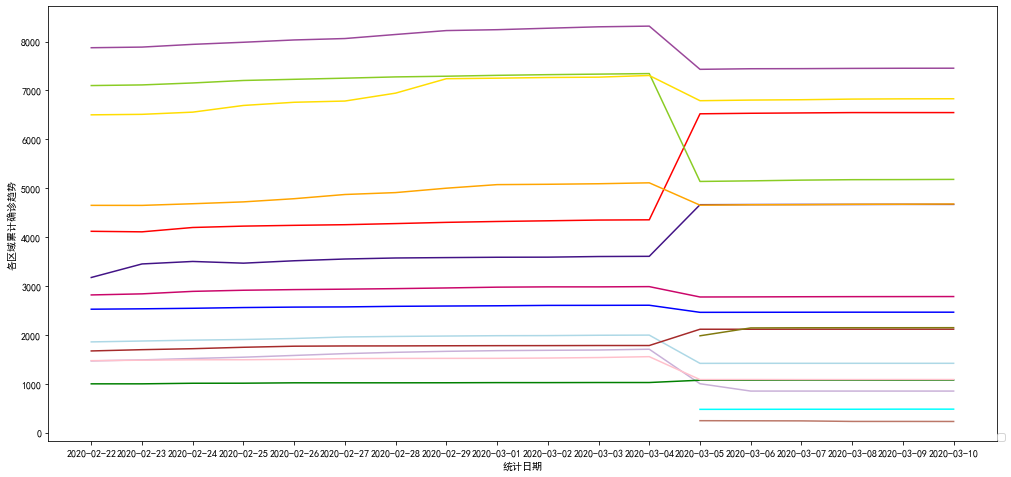

In [27]:
plt.figure(figsize=(17,8))
x = df_wh.date.sort_values(ascending=True)
plt.xlabel("统计日期")
plt.ylabel('各区域累计确诊趋势')
plt.legend(bbox_to_anchor=(1,0), loc=3, borderaxespad=0,labels=df_loc.columns[1:])
for i,location in enumerate(df_loc.columns):
    if location == 'date':
        continue
    y = df_wh[location]
    plt.plot(x,y,color=colors_list[i],label=location)
    print(f"地区：{location}，颜色：{colors_list[i]}")

In [28]:
df_loc_increase = pd.DataFrame(df_new.date,columns=df_loc.columns)
for location in df_loc.columns[1:]:
    print(location)
    df_loc_increase[str(location)] = df_wh[str(location)] - df_wh.shift(periods=-1)[str(location)]
df_loc_increase = df_loc_increase.sort_values(by='date',ascending=True)
df_loc_increase

loc_ja
loc_jh
loc_qk
loc_hy
loc_wc
loc_qs
loc_hs
loc_dxh
loc_cd
loc_jx
loc_hp
loc_xz
loc_hn
loc_gg
loc_ddfjq
loc_outer


,date,loc_ja,loc_jh,loc_qk,loc_hy,loc_wc,loc_qs,loc_hs,loc_dxh,loc_cd,loc_jx,loc_hp,loc_xz,loc_hn,loc_gg,loc_ddfjq,loc_outer
17,2020-02-22,11.0,-13.0,-10.0,-277.0,-13.0,-22.0,1.0,-8.0,-18.0,-21.0,-26.0,0.0,-10.0,NaN,NaN,NaN
16,2020-02-23,-89.0,-40.0,-45.0,-51.0,-56.0,-51.0,-34.0,-11.0,-18.0,-29.0,-20.0,-12.0,-8.0,NaN,NaN,NaN
15,2020-02-24,-28.0,-51.0,-137.0,35.0,-43.0,-23.0,-38.0,-15.0,-13.0,-26.0,-29.0,-1.0,-1.0,NaN,NaN,NaN
14,2020-02-25,-16.0,-24.0,-65.0,-49.0,-47.0,-13.0,-65.0,-9.0,-21.0,-36.0,-22.0,-8.0,-8.0,NaN,NaN,NaN
13,2020-02-26,-13.0,-23.0,-25.0,-36.0,-29.0,-9.0,-86.0,-4.0,-31.0,-37.0,-5.0,0.0,-15.0,NaN,NaN,NaN
12,2020-02-27,-23.0,-26.0,-162.0,-21.0,-83.0,-11.0,-39.0,-12.0,-11.0,-27.0,-1.0,0.0,-4.0,NaN,NaN,NaN
11,2020-02-28,-25.0,-14.0,-295.0,-8.0,-80.0,-14.0,-90.0,-6.0,-8.0,-20.0,-3.0,-1.0,-1.0,NaN,NaN,NaN
10,2020-02-29,-18.0,-18.0,-11.0,-7.0,-18.0,-16.0,-73.0,-5.0,-7.0,-14.0,-2.0,-3.0,-1.0,NaN,NaN,NaN
9,2020-03-01,-14.0,-14.0,-14.0,-2.0,-30.0,-6.0,-7.0,-8.0,-2.0,-7.0,-1.0,0.0,-6.0,NaN,NaN,NaN
8,2020-03-02,-15.0,-11.0,-7.0,-13.0,-29.0,0.0,-11.0,-1.0,-7.0,-6.0,-2.0,-2.0,-10.0,NaN,NaN,NaN


地区：loc_ja，颜色：red
地区：loc_jh，颜色：#8acc24
地区：loc_qk，颜色：#ffdd01
地区：loc_hy，颜色：#421386
地区：loc_wc，颜色：#9a479a
地区：loc_qs，颜色：#ca066a
地区：loc_hs，颜色：orange
地区：loc_dxh，颜色：blue
地区：loc_cd，颜色：lightblue
地区：loc_jx，颜色：#c9b0d8
地区：loc_hp，颜色：brown
地区：loc_xz，颜色：green
地区：loc_hn，颜色：pink
地区：loc_gg，颜色：#80790e
地区：loc_ddfjq，颜色：aqua
地区：loc_outer，颜色：#bb7768


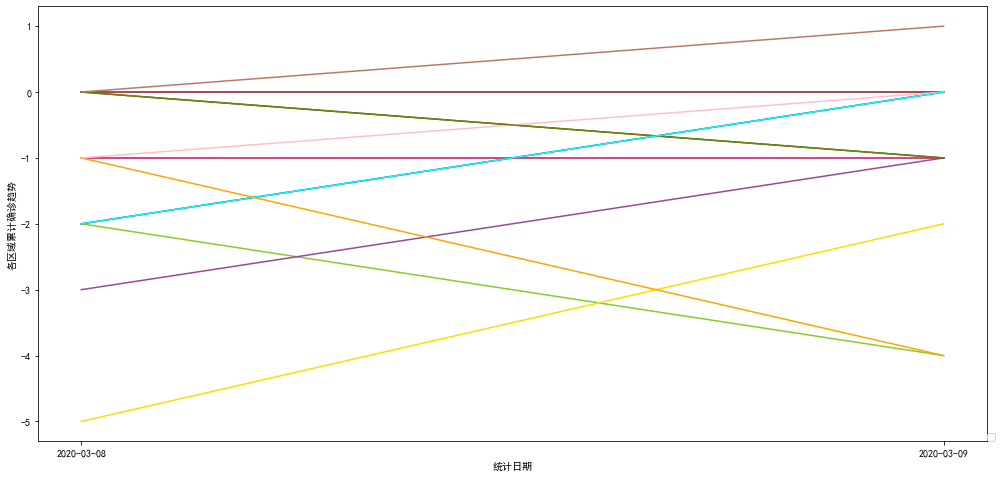

In [29]:
colors_list = ['red','#8acc24','#ffdd01','#421386','#9a479a','#ca066a','orange','blue','lightblue','#c9b0d8',\
          'brown','green','pink','#80790e','aqua','#bb7768']
plt.figure(figsize=(17,8))
x = df_loc_increase.date.tail(3)
plt.xlabel("统计日期")
plt.ylabel('各区域累计确诊趋势')
plt.legend(bbox_to_anchor=(1,0), loc=3, borderaxespad=0,labels=df_loc_increase.columns[1:])
for i,location in enumerate(df_loc_increase.columns[1:]):
    y = df_loc_increase[location].tail(3)
    plt.plot(x,y,color=colors_list[i],label=location)
    print(f"地区：{location}，颜色：{colors_list[i]}")

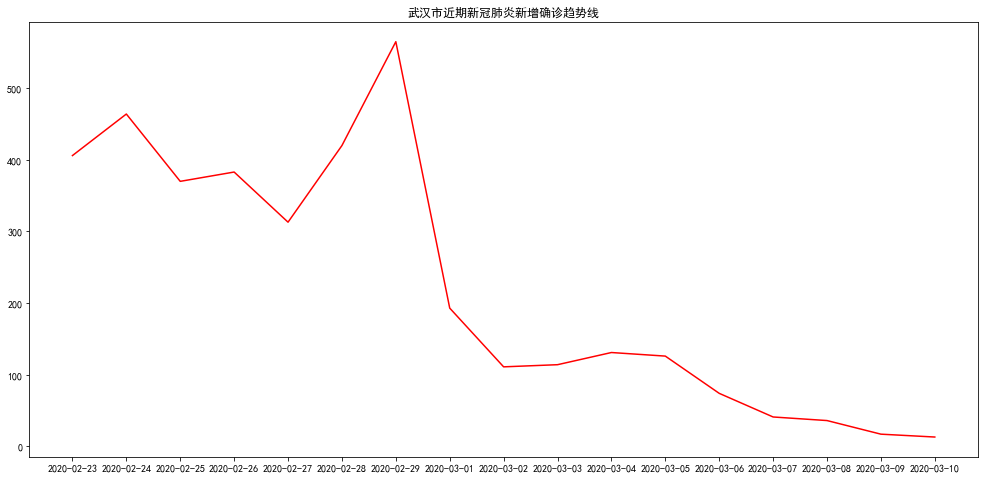

In [30]:
df_wh[['date','new_confirm']]
plt.figure(figsize=(17,8))
x = df_wh.date
y = df_wh.new_confirm
plt.title('武汉市近期新冠肺炎新增确诊趋势线')
plt.plot(x,y,color='red')

E:\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


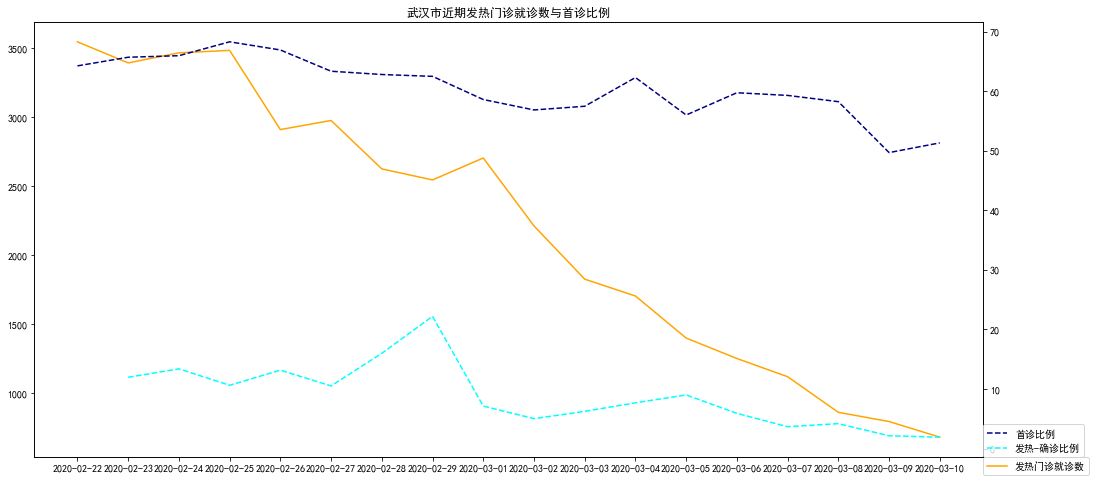

In [31]:
fig = plt.figure(figsize=(17,8))
plt.title('武汉市近期发热门诊就诊数与首诊比例')
ax1 = fig.add_subplot(111)
y1 = df_wh.fever_clinics
ax1.plot(x,y1,color='orange',label='发热门诊就诊数')
plt.legend(bbox_to_anchor=(1,0),loc=2, borderaxespad=0)
ax2 = ax1.twinx()
y2 = round(df_wh.first_visit/df_wh.fever_clinics,4)*100
ax2.plot(x,y2,color='navy',label='首诊比例',linestyle='dashed')
plt.legend(bbox_to_anchor=(1,0),loc=3, borderaxespad=0)
y3 = round(df_wh.new_confirm/df_wh.fever_clinics,4)*100
ax2.plot(x,y3,color='aqua',label='发热-确诊比例',linestyle='dashed')
plt.legend(bbox_to_anchor=(1,0),loc=3, borderaxespad=0)

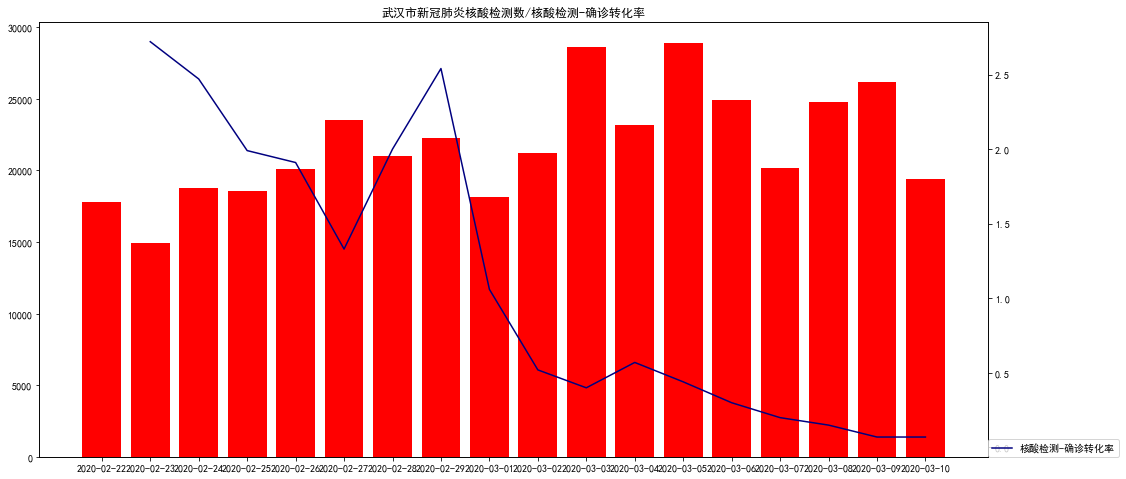

In [33]:
fig = plt.figure(figsize=(17,8))
ax3 = fig.add_subplot(111)
plt.title('武汉市新冠肺炎核酸检测数/核酸检测-确诊转化率')
y4 = df_wh.nucleic_acid_testing
ax3.bar(x,y4,color='red',label='核酸检测数')
ax4 = ax3.twinx()
y5 = round(df_wh.new_confirm/df_wh.nucleic_acid_testing,4)*100
ax4.plot(x,y5,color='navy')
plt.legend(bbox_to_anchor=(1,0),loc=3,borderaxespad=0,labels=['核酸检测-确诊转化率'])

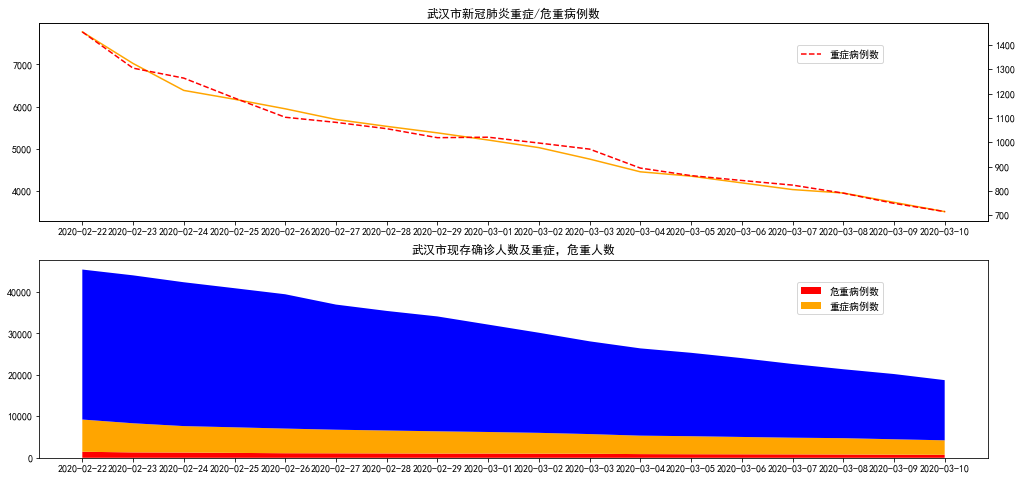

In [36]:
fig = plt.figure(figsize=(17,8))
ax3 = fig.add_subplot(211)
plt.title('武汉市新冠肺炎重症/危重病例数')
y4 = df_wh.rest_heavy
ax3.plot(x,y4,color='orange',label='重症病例数')
ax4 = ax3.twinx()
y5 = df_wh.rest_dangerous
ax4.plot(x,y5,color='red',label='危重病例数',linestyle='dashed')
plt.legend(bbox_to_anchor=(0.89,0.89),loc=1,borderaxespad=0,labels=['重症病例数','危重病例数'])
ax5 = fig.add_subplot(212)
plt.title('武汉市现存确诊人数及重症，危重人数')
y_rest_total = df_wh.total_rest
y_rest_heavy = df_wh.rest_heavy
y_rest_dangerous = df_wh.rest_dangerous
ax5.stackplot(x,y_rest_dangerous,y_rest_heavy,y_rest_total,colors=['red','orange','blue'],labels=['重症','危重'])
plt.legend(bbox_to_anchor=(0.89,0.89),loc=1,borderaxespad=0,labels=['危重病例数','重症病例数'])

E:\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


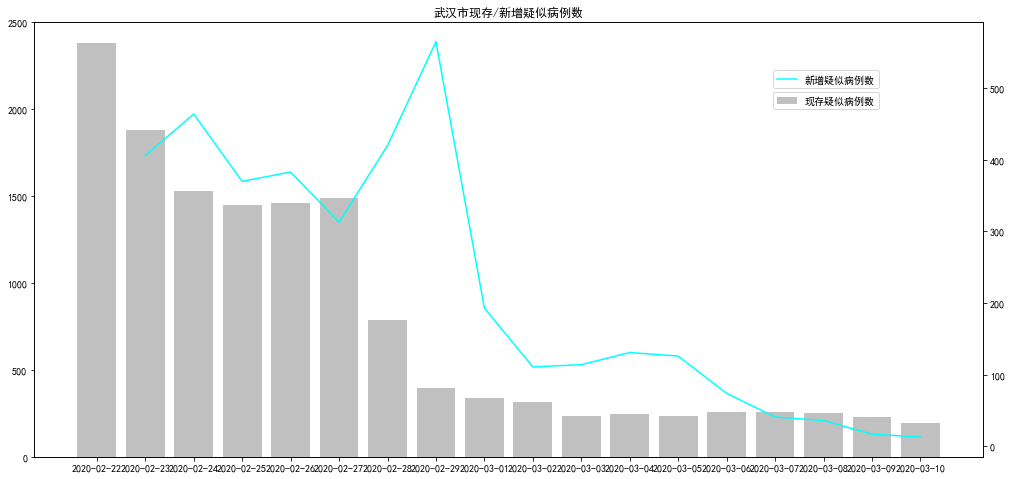

In [42]:
fig = plt.figure(figsize=(17,8))
plt.title("武汉市现存/新增疑似病例数")
ax6 = fig.add_subplot(111)
y6 = df_wh.total_seemingly
ax6.bar(x,y6,label='现存疑似病例数',color='silver')
plt.legend(bbox_to_anchor=(0.89,0.84),loc=1,borderaxespad=0,labels=['现存疑似病例数'])
ax7 = ax6.twinx()
y7 = df_wh.new_confirm
ax7.plot(x,y7,label='新增疑似病例数',color='aqua')
plt.legend(bbox_to_anchor=(0.89,0.89),loc=1,borderaxespad=0,labels=['新增疑似病例数'])

In [43]:
def collect_other_section(loc_key):
    if str(loc_key) in ['loc_ja','loc_jh','loc_qk','loc_hy','loc_wc','loc_hs']:
        return dict_loc[loc_key]
    else:
        return '其它'

E:\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  from ipykernel import kernelapp as app


([<matplotlib.patches.Wedge at 0x2ca81883e10>,
 [Text(0.6668868870805187, 0.8747924781569945, '其它'),
  Text(-0.7389916990267017, 0.8147952311897934, '武昌区'),
  Text(-1.0971371306619702, 0.07931025484021184, '汉阳区'),
  Text(-0.8870488259086511, -0.6504954884194692, '江岸区'),
  Text(-0.21964100125181815, -1.0778487048603338, '江汉区'),
  Text(0.44692164327564315, -1.0051174283494437, '洪山区'),
  Text(1.0001978461627, -0.45782558745825497, '硚口区')],
 [Text(0.3637564838621011, 0.47715953354017876, '29.27%'),
  Text(-0.4030863812872918, 0.44443376246716, '14.91%'),
  Text(-0.598438434906529, 0.043260139003751905, '9.34%'),
  Text(-0.48384481413199143, -0.3548157209560741, '13.10%'),
  Text(-0.1198041825009917, -0.5879174753783638, '10.36%'),
  Text(0.24377544178671443, -0.5482458700087874, '9.35%'),
  Text(0.5455624615432908, -0.24972304770450265, '13.66%')])

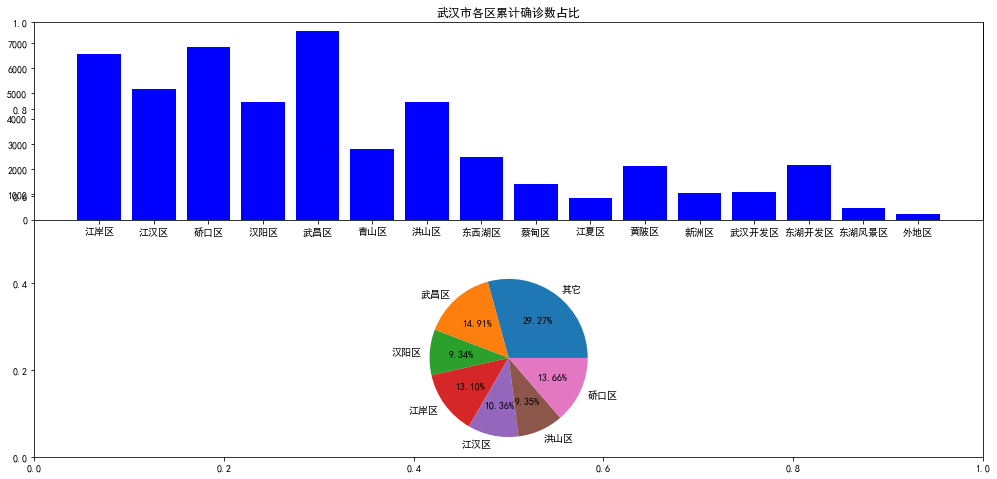

In [47]:
fig = plt.figure(figsize=(17,8))
plt.title("武汉市各区累计确诊数占比")
ax8 = fig.add_subplot(211)
x1 = df_loc.columns[1:] 
x1_out = pd.Series(x1).apply(lambda x:dict_loc[x])
x1_out
y8 = df_wh.sort_values(by='date',ascending=False).iloc[0][x1]
plt.bar(x1_out,y8,color='blue',label='武汉市各区累计确诊数')
ax9 = fig.add_subplot(212)
df_loc_distribution = pd.DataFrame(data=y8)
df_loc_distribution['loc_label'] = pd.Series(y8.index.values).apply(collect_other_section).values
df_loc_distribution.rename(columns={0:'loc_count'},inplace=True)
s2 = df_loc_distribution.groupby('loc_label').sum()
# print(s2.index.values)
ax9.pie(s2,autopct='%1.2f%%',labels=s2.index.values)

### Draft

In [28]:
content_test = '江岸区6521例、江汉区5137例、硚口区6789例、汉阳区4661例、武昌区7431例、青山区2773例、洪山区4652例、东西湖区2459例、\
                蔡甸区1415例、江夏区998例、黄陂区2113例、新洲区1070例、武汉开发区(汉南)1083例、东湖开发区1979例、东湖风景区474例、外地242例'
pa = re.compile('\w+区')
loc_li = pa.findall(content_test)
loc_li
#loc_li.index('洪山区')     #6

['江岸区',
 '江汉区',
 '硚口区',
 '汉阳区',
 '武昌区',
 '青山区',
 '洪山区',
 '东西湖区',
 '蔡甸区',
 '江夏区',
 '黄陂区',
 '新洲区',
 '武汉开发区',
 '东湖开发区',
 '东湖风景区']

In [34]:
str_test = '2020年3月5日'
pa_d = re.compile('\d+年\d+月\d+日')
pa_d.findall(str_test)

['（']

In [68]:
p2 = ['累计治愈出院27354人','累计死亡2328人。全市现有确诊病例20115人（危重863人','重症4345人）','现有疑似病例232例。']
for te in p2:
    q = te.split('。')
    print(q)

['累计治愈出院27354人']
['累计死亡2328人', '全市现有确诊病例20115人（危重863人']
['重症4345人）']
['现有疑似病例232例', '']


In [24]:
publish_Time = "2018年10月10日"
array = time.strptime(publish_Time, u"%Y年%m月%d日")
publishTime = time.strftime("%Y-%m-%d", array)
print(publishTime)

2018-10-10


In [48]:
list_n = ['AD','E','V',[1,2,4,6]]
type(list_n[-2])

str

In [70]:
total_stat_list

[['date',
  'total_confirm',
  'total_cure',
  'total_dead',
  'total_rest',
  'rest_dangerous',
  'rest_heavy',
  'total_seemingly'],
 ['2020-03-07', '49912', '29770', '2370', '17772', '824', '4026', '258'],
 ['2020-03-06', '49871', '28511', '2349', '19011', '843', '4185', '256'],
 ['2020-03-05', '49797', '27354', '2328', '20115', '863', '4345', '232'],
 ['2020-03-04', '49671', '26316', '2305', '21050', '894', '4448', '247'],
 ['2020-03-03', '49540', '24890', '2282', '22368', '972', '4751', '234'],
 ['2020-03-02', '49426', '23031', '2251', '24144', '997', '5023', '316'],
 ['2020-03-01', '49315', '21185', '2227', '25903', '1021', '5204', '340'],
 ['2020-02-29', '49122', '19227', '2195', '27700', '1019', '5374', '393'],
 ['2020-02-28', '48557', '17552', '2169', '28836', '1056', '5529', '788'],
 ['2020-02-27', '48137', '15826', '2132', '30179', '1082', '5693', '1488'],
 ['2020-02-26', '47824', '13328', '2104', '32392', '1103', '5946', '1459'],
 ['2020-02-25', '47441', '11793', '2085', '3

In [51]:
?df_whole.shift

In [59]:
df_test1 = pd.DataFrame([[8,4],[8,3]],columns=['a','b'])
df_test2 = pd.DataFrame([[5,0],[3,9]],columns=['a','b'])

In [60]:
df_test2

,a,b
0,5,0
1,3,9


In [ ]:
def minus_row(df_work):
    

In [82]:
#df_test2.insert(2,'d',df_test2.a-df_test2.shift(periods=-1).a)
df_test2.drop('c',axis=1)

,a,d,b
0,5,2.0,0
1,3,NaN,9


In [68]:
df_daily['compare_last_night'] = df_daily.apply(df_daily.fever_clinics.astype(float)-df_daily.shift(periods=-1).fever_clinics.astype(float))
df_daily

ValueError: no results

In [90]:
df_test1.insert(2,'c',[6,None])
df_test1

,a,b,c
0,8,4,6.0
1,8,3,NaN


In [131]:
df_t = pd.DataFrame([0,1,None])
df_t.T

,0,1,2
0,0.0,1.0,NaN


In [171]:
#df_test1 = df_test1.append(df_t.T,ignore_index=True)
df_test1 = df_test1.c.fillna(mi)
df_test1

0    6.0
1    2.0
2    NaN
Name: c, dtype: float64

In [169]:
mi = df_test1.a-df_test1.shift(periods=-1,axis=0).a
mi

0    0.0
1    2.0
2    NaN
Name: a, dtype: float64

In [179]:
df_da = pd.DataFrame([[3,6,1],[4,2,None],[7,8,None],[6,9,None]],columns=['a','b','c'])
df_da

,a,b,c
0,3,6,1.0
1,4,2,NaN
2,7,8,NaN
3,6,9,NaN


In [184]:
df_da.c = df_da.c.fillna(df_da.a-df_da.shift(periods=-1).a)
df_da.c

0    1.0
1   -3.0
2    1.0
3    NaN
Name: c, dtype: float64

In [186]:
df_da.a-df_da.shift(periods=-1).a

0   -1.0
1   -3.0
2    1.0
3    NaN
Name: a, dtype: float64

TypeError: 'str' object is not callable

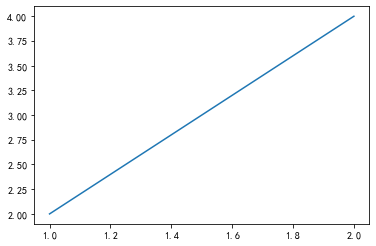

In [405]:
plt.plot([2,1],[4,2])
plt.title('f**k')

In [396]:
d1 = dict(zip(['a','b','c'],[1,2,3]))
d1

{'a': 1, 'b': 2, 'c': 3}

In [399]:
d1['b']

2